In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy.stats as st
from pandas.plotting import scatter_matrix
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

def PC_prop(seq_list,alphabet,AAindex_loc,PCprop):
    AAindex = pd.read_csv(AAindex_loc)
    PCrow = AAindex.loc[AAindex['Property']==PCprop]
    PC_list = []
    for i in range(0,len(seq_list)):
        PC_vec = []
        seq_str = seq_list.iloc[i]
        for j in range(0,len(seq_str)):
            ind = alphabet.find(seq_str[j])
            if ind!=-1:
                PC_vec += PCrow[alphabet[ind]].tolist()
        PC_list.append(PC_vec)
    return PC_list

def digitalize(PC_list):
    length_seq = []
    for i in range(0,len(PC_list)):
        length_seq += [len(PC_list[i])]
    max_len = max(length_seq)
    pad_power = mt.ceil(mt.log(max_len, 2))
    pad_len = 2**pad_power
    nyq_lim = pad_len/2
    for i in range(0,len(PC_list)):
        PC_list[i] = PC_list[i] + [0]*(pad_len - len(PC_list[i]))
    digi_list = []
    for i in range(0,len(PC_list)):
        digi_vec = np.abs(sc.fft(PC_list[i]))
        digi_vec = digi_vec[0:int(nyq_lim)]
        digi_vec = [2*elem/pad_len for elem in digi_vec]
        digi_list.append(digi_vec)
    return digi_list

def subcategorybar(X, vals, labels, width=0.8, zorder=3):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", zorder=3, label=labels[i])   
    plt.xticks(_X, X)
    
class characterizations:
    
    props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
    props_labels = ['Alpha group','Beta group','Energetic group','Hydrophilicity group','Hydrophobicity group',
                   'Secondary structure group','Volume group','Index group']
    alphabet = 'ARNDCQEGHILKMFPSTWYV'
    alph_labels = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    
    def __init__(self,dataset_path):
        if dataset_path.endswith('.csv'):
            self.dataset = pd.read_csv(dataset_path)
            self.subsetname = os.path.basename(dataset_path)[0:-4]
            self.setname = self.subsetname[0].split(' ', 1)[0]
            self.path = dataset_path

    def remove_outliers(self):
        col_names=list(self.dataset.columns.values)
        if col_names[2]=='is_outlier':
            outliers = self.dataset['is_outlier']
            self.dataset = self.dataset[outliers != 1]
            self.dataset.reset_index(drop=True, inplace=True)
        
    def check_type(self):
        probtype = self.dataset.columns[1]
        if probtype=='class':
            if len(list(set(self.dataset['class'])))==2:
                self.type = 'classification'
            elif len(list(set(self.dataset['class'])))>2:
                self.type = 'multi-label'
        elif probtype=='response':
            self.type = 'regression'
        else:
            print('THERE IS NO VALID PROBLEM TYPE')
            return
        return self.type
    
    def distr_classes(self):
        if self.check_type()=='classification':
            pos = self.dataset[self.dataset['class']==1]
            neg = self.dataset[self.dataset['class']==0]
            return [['clase positiva', 'clase negativa'], [pos,neg]]
        elif self.check_type()=='multi-label':
            categories = np.unique(self.dataset['class'])
            subsets = []
            for cat in categories:
                subset = self.dataset[self.dataset['class']==cat]
                subsets.append(subset)
            return [categories, subsets]
        else:
            return [[''],[self.dataset]]

    def peptide_length_hist(self,exportpath, bins=15, classplot=0, alpha=1):
        palette = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101', '#fdfc33', '#a8572c', '#f482be', '#999999']
        seq = self.dataset['sequence']
        peplen = [len(seq[i]) for i in range(0,len(seq))]
        maxlen = max(peplen)
        self.dataset['Largo de secuencia'] = peplen
        checktype = self.check_type()
        fig = plt.figure(figsize=(8, 6))
        if checktype=='multi-label' or checktype=='classification':
            classes = self.dataset['class'].unique().tolist()
            for group in [classes[classplot-1]]:
                df = self.dataset[self.dataset['class']==group]
                #subdataframs += [df]
                plt.hist(df['Largo de secuencia'].tolist(),zorder=3,edgecolor='black', linewidth=1, bins=bins, alpha=alpha, color=palette[classplot])
        elif checktype=='regression':
            plt.hist(peplen,zorder=3,edgecolor='black', linewidth=1, bins=bins)
        if classplot!=0:
            group = classes[classplot-1]
            if type(group)==int:
                if group==1:
                    group = 'positiva'
                elif group==0:
                    group = 'negativa'
            fig.suptitle('Histograma de ' + self.subsetname + ' para clase ' + group, fontsize=14)
            plt.xlabel('Largo de secuencia', fontsize=14)
            plt.ylabel('Frecuencia', fontsize=14)
            plt.grid(zorder=0)
            filename = exportpath+'/Histogram '+self.subsetname + ' clase ' + group + '.png'
            plt.savefig(filename,format='png')
        elif classplot==0:
            group = ''
            fig.suptitle('Histograma de ' + self.subsetname, fontsize=14)
            plt.xlabel('Largo de secuencia', fontsize=14)
            plt.ylabel('Frecuencia', fontsize=14)
            plt.grid(zorder=0)
            filename = exportpath+'/Histogram '+self.subsetname + '.png'
            plt.savefig(filename,format='png')

    def peptide_length_kde(self,exportpath):
        palette = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101', '#fdfc33', '#a8572c', '#f482be', '#999999']
        seq = self.dataset['sequence']
        peplen = [len(seq[i]) for i in range(0,len(seq))]
        maxlen = max(peplen)
        self.dataset['Largo_de_secuencia'] = peplen
        checktype = self.check_type()
        fig = plt.figure(figsize=(8, 6))
        if checktype=='multi-label' or checktype=='classification':
            self.dataset.groupby("class").Largo_de_secuencia.plot(y=['Densidad'], title='Estimación de densidad kernel de '+self.subsetname,
                                                                  kind='kde', grid=True, legend=True,
                                                                  xlim=(self.dataset['Largo_de_secuencia'].min(),self.dataset['Largo_de_secuencia'].max()))
            plt.ylabel('Densidad', fontsize=12)
            plt.xlabel('Largo de secuencia', fontsize=12)
            plt.title('Estimación de densidad kernel para '+self.subsetname, fontsize=14)
            filename = exportpath+'/kde '+self.subsetname + '.png'
            plt.savefig(filename,format='png')

    def AAC_bar(self,exportpath):
        classes = self.distr_classes()
        aa = [i for i in self.alphabet]
        AAC = []
        for i in range(0,len(classes[1])):
            seq = classes[1][i]['sequence']
            AAC_vec = [0]*len(self.alphabet)
            for k in range(0,len(seq)):
                for j in range(0,len(seq.iloc[k])):
                    ind = self.alphabet.find(seq.iloc[k][j])
                    if ind!=-1:
                        AAC_vec[ind]+=1
            N = sum(AAC_vec)
            AAC_vec = [aac/N for aac in AAC_vec]
            AAC.append(AAC_vec)
        fig = plt.figure(figsize=(10,6))
        labels = classes[0]
        subcategorybar(aa,AAC,labels,width=0.8,zorder=3)
        fig.suptitle('Composición de aminoácidos de \n' + self.subsetname, fontsize=14)
        plt.xlabel('Residuo',fontsize=14)
        plt.ylabel('Composición [%]', fontsize=14)
        plt.grid(zorder=0)
        plt.legend(loc="upper right")
        filename = exportpath+'/AAC_bar_' + self.subsetname + '.png'
        plt.savefig(filename,format='png')
        ##### verificar label legend para type de regresión ####
        
    
    def AAC_heatmap(self,exportpath):
        classes = self.distr_classes()
        aa = [i for i in self.alphabet]
        AAC = []
        for i in range(0,len(classes[1])):
            seq = classes[1][i]['sequence']
            AAC_vec = [0]*len(self.alphabet)
            for k in range(0,len(seq)):
                for j in range(0,len(seq.iloc[k])):
                    ind = self.alphabet.find(seq.iloc[k][j])
                    if ind!=-1:
                        AAC_vec[ind]+=1
            N = sum(AAC_vec)
            AAC_vec = [aac/N for aac in AAC_vec]
            AAC.append(AAC_vec)
        labels = classes[0]
        heatmatrix = np.array(AAC)
        fig = plt.figure(figsize=(10,2))
        plt.imshow(heatmatrix)
        labels = classes[0]
        fig.suptitle('Composición de aminoácidos de \n' + self.subsetname, fontsize=14)
        plt.xlabel('Residuo',fontsize=14)
        plt.xticks(np.arange(len(self.alphabet)),aa)
        plt.yticks(np.arange(len(labels)),labels)
        plt.colorbar()
        filename = exportpath+'/AAC_heatmap_' + self.subsetname + '.png'
        plt.savefig(filename,format='png')
        
    def dipeptide_heatmap(self,exportpath):
        classes = self.distr_classes()
        aa = [i for i in self.alphabet]
        max_accum = []
        heatmatrices = []
        for i in range(0,len(classes[1])):
            dipept_quant = []
            subset = classes[1][i].reset_index(drop=True)
            seq = subset['sequence']
            dipept_comp = np.zeros((len(self.alphabet),len(self.alphabet)),dtype=int)   ## rows=first aa, columns=second aa
            for k in range(0,len(seq)):
                dipept_quant += [len(seq.iloc[k])-1]
                for j in range(0,len(seq.iloc[k])-1):
                    ind_first = self.alphabet.find(seq.iloc[k][j])
                    ind_second = self.alphabet.find(seq.iloc[k][j+1])
                    if ind_first!=-1 and ind_second!=-1:
                        dipept_comp[ind_first,ind_second] += 1
            total_dipept_quant = np.sum(dipept_quant)
            N = total_dipept_quant
            heatmatrix=dipept_comp/N
            max_accum += [np.max(heatmatrix)]
            heatmatrices.append(heatmatrix)
        for i in range(0,len(classes[1])):
            fig = plt.figure(figsize=(8,6))
            plt.imshow(heatmatrices[i])
            fig.suptitle('Composición de aminoácidos de \n' + self.subsetname + ' ' + str(classes[0][i]), fontsize=14)
            plt.xlabel('Primer residuo',fontsize=14)
            plt.ylabel('Segundo residuo',fontsize=14)
            plt.xticks(np.arange(len(self.alphabet)),aa)
            plt.yticks(np.arange(len(self.alphabet)),aa)
            plt.clim((0,max(max_accum)))
            plt.colorbar()
            filename = exportpath+'/AAC_heatmap_' + str(classes[0][i]) + ' ' + self.subsetname + '.png'
            plt.savefig(filename,format='png')
            
            ###FALTA NORMALIZAR COLORBAR PARA UN MISMO SET 
    
    def pie_chart_response(self,exportpath):
        if self.check_type()=='regression':
            return
        classes = self.distr_classes()
        if self.check_type()=='classification' or self.check_type()=='multi-label':
            N_val =[]
            for i in range(0,len(classes[1])):
                values = classes[1][i]['class']
                N_val += [len(values)]
            labels = [str(name) for name in classes[0]]
            fig = plt.figure(figsize=(8,6))
            plt.pie(N_val, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90,
                    wedgeprops={"edgecolor":"0",'linewidth': 0.5, 'antialiased': True},
                   textprops={'fontsize':14, 'color':'black'}, pctdistance=0.85)
            plt.axis('equal')
            fig.suptitle('Distribución de clases de \n' + self.subsetname, fontsize=14)
            filename = exportpath+'/piechart_response ' + self.subsetname + '.png'
            plt.savefig(filename,format='png')
            
    
    def histogram_response(self,exportpath):
        if self.check_type()=='classification' or self.check_type()=='multi-label':
            return
        values = self.dataset['response']
        values = values.dropna()
        fig = plt.figure(figsize=(8, 6))
        plt.hist(values,zorder=3,edgecolor='black', linewidth=1, bins=100)
        plt.title('Histograma de ' + self.subsetname, fontsize=14)
        plt.xlabel('Magnitud de respuesta', fontsize=14)
        plt.ylabel('Frecuencia', fontsize=14)
        plt.ylim((0,200))
        plt.grid(zorder=0)
        filename = exportpath+'/Histogram_response ' + self.subsetname + '.png'
        plt.savefig(filename,format='png')
        
    def histogram_response_wo_outliers(self,exportpath):
        if self.check_type()=='classification' or self.check_type()=='multi-label':
            return
        values = self.dataset['response']
        values = values.dropna()
        Q1 = np.quantile(values,0.25)
        Q3 = np.quantile(values,0.75)
        IQR = Q3 - Q1
        new_val = [i for i in values if i <= Q3 + 1.5*IQR]
        fig = plt.figure(figsize=(8, 6))
        plt.hist(new_val,zorder=3,edgecolor='black', linewidth=1, bins=100)
        plt.title('Histograma de ' + self.subsetname, fontsize=14)
        plt.xlabel('Magnitud de respuesta', fontsize=14)
        plt.ylabel('Frecuencia', fontsize=14)
        plt.grid(zorder=0)
        filename = exportpath+'/Histogram_response ' + self.subsetname + '.png'
        plt.savefig(filename,format='png')
    
    def box_plot_response(self,exportpath):
        if self.check_type()=='classification' or self.check_type()=='multi-label':
            return
        values = self.dataset['Valor']
        fig = plt.figure(figsize=(4, 6))
        c = 'darkorange'
        plt.boxplot(values,zorder=3,showmeans=True, patch_artist=True,
                   boxprops={'facecolor': c,'color':'black','linewidth':0.5}, capprops={'color':'black','linewidth':1.2},
                   whiskerprops={'color':'black','linewidth':1.2}, flierprops={'color':c, 'markeredgecolor':c},
                   medianprops={'color':'black','linewidth':1.2}, 
                    meanprops={'marker':'D', 'markeredgecolor':'black', 'markerfacecolor':'green','markersize':7}, labels=[''])
        plt.title('Boxplot de ' + self.subsetname, fontsize=14)
        plt.ylabel('Magnitud de respesuta', fontsize=14)
        plt.grid(zorder=0)
        filename = exportpath+'/Boxplot ' + self.subsetname + '.png'
        plt.savefig(filename,format='png')
        
    def box_plot_length(self,exportpath):
        classes = self.distr_classes()
        fig = plt.figure(figsize=(4, 6))
        seqlens = []
        for i in range(0,len(classes[1])):
            seq = classes[1][i]['Secuencia']
            seqlen = []
            for seq_str in seq:
                seqlen += [len(seq_str)]
            seqlens.append(seqlen)
        c = 'darkorange'
        plt.boxplot(seqlens,zorder=3,showmeans=True, patch_artist=True,
                    boxprops={'facecolor': c,'color':'black','linewidth':0.5}, capprops={'color':'black','linewidth':1.2},
                    whiskerprops={'color':'black','linewidth':1.2}, flierprops={'color':c, 'markeredgecolor':c},
                    medianprops={'color':'black','linewidth':1.2}, 
                    meanprops={'marker':'D', 'markeredgecolor':'black', 'markerfacecolor':'green','markersize':7}, labels = classes[0])
        plt.title('Boxplot de largo de secuencias \n de ' + self.subsetname, fontsize=14)
        plt.ylabel('Largo de secuencia', fontsize=14)
        plt.grid(zorder=0)
        filename = exportpath+'/Boxplot_seqlen ' + self.subsetname + '.png'
        plt.savefig(filename,format='png')
    
    def AAC_encoding(self):
        seq = self.dataset['Secuencia']
        ACC_list = composition(seq,self.alphabet)
        columns_enc = [letter for letter in self.alphabet]
        columns = ['ID','Valor']+columns_enc
        rows = [k for k in range(0,len(seq))]
        datacells = np.zeros((len(seq),len(ACC_list[0])+2))
        datacells[:,0]=self.dataset['ID']
        datacells[:,1]=self.dataset['Valor']
        for k in range(0,len(seq)):
            for j in range(0,len(ACC_list[0])):
                datacells[k,j+2] = ACC_list[k][j]         
        self.AAC_enc = pd.DataFrame(datacells,index=rows,columns=columns)
        return self.AAC_enc
    
    def scatter_AAC(self,palette=None):
        if len(self.alphabet)>4:
            print('Warning! Due to non-compact alphabet, plotting will take a while...')
        AAC_df = self.AAC_encoding()
        data = AAC_df[[letter for letter in self.alphabet] + ['Valor']]
        if palette is None:
            palette = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101', '#fdfc33', '#a8572c', '#f482be', '#999999']
        values = AAC_df['Valor'] #extract column
        df = AAC_df[[i for i in self.alphabet]]
        classes = list(set(values))
        color_map = dict(zip(classes,palette))
        if len(classes) > len(palette):
            raise ValueError('''Too many groups for the number of colors provided. 
            We only have {} colors in the palette, but you have {} groups.'''.format(len(palette), len(classes)))
        colors = values.apply(lambda group: color_map[group])
        axarr = scatter_matrix(df,figsize=(10,10),marker='o',c=colors,diagonal=None)
        labels = [i for i in df.columns]
        for i in range(0,len(labels)):
            for group in classes:
                y = df[values == group][labels[i]]
                gkde = st.gaussian_kde(y.transpose())
                ind = np.linspace(y.min(), y.max(), 100)
                axarr[i][i].plot(ind, gkde.evaluate(ind),c=color_map[group])
        return axarr, color_map

##############################################################################################################
##############################################################################################################
##############################################################################################################
##############################################################################################################
##############################################################################################################

def spectrum_density_filled_raw(df,exportpath,prop,subsetname,resol=32,form='png'):
    df.subsetname = subsetname
    print(df.subsetname)
    max_all = []
    for i in range(0,len(df.dataset)):
        max_row = max(df.dataset.iloc[i].tolist()[1:])
        max_all += [max_row]
    max_all = max(max_all)
    col = df.dataset.columns[0]
    if col=='response':
        categories = ['']
        subsets = [df.dataset]
    elif col=='class':
        categories = list(set(df.dataset[col]))
        subsets = []
        for i in range(0,len(categories)):
            subset = df.dataset[df.dataset[col]==categories[i]]                          #####SPECTRUM DENSITY FILLED RAW
            subsets.append(subset)
    heatmaps = []
    for i in range(0,len(categories)):
        subset = subsets[i]
        subset.reset_index(drop=True, inplace=True)
        category = categories[i]
        heatmap = np.zeros((resol,len(df.dataset.columns)-1))
        Yvec = [max_all/resol*i for i in range(1,resol+1)]
        for j in range(0,len(subset)):
            for k in range(0,len(df.dataset.columns)-1):
                row = subset.iloc[j].tolist()[1:]
                elem = row[k]
                ind = next(x[0] for x in enumerate(Yvec) if x[1] >= elem)
                heatmap[:ind,k] += 1
        heatmap = np.flipud(heatmap)
        heatmaps.append(heatmap)
    max_maps = []
    for i in range(0,len(categories)):
        max_maps += [np.max(heatmaps[i])]
    max_all_maps = max(max_maps)
    for i in range(0,len(categories)):
        n_samples = len(subsets[i])
        heatmaps[i] = heatmaps[i]/n_samples
    for i in range(0,len(categories)):
        fig = plt.figure(figsize=(8,8))
        plt.imshow(heatmaps[i], aspect='auto',interpolation='bilinear', cmap=plt.get_cmap('jet'))
        if len(categories)==1:
            plt.title('Espectro multicanal (' + prop + ')', fontsize=16)
        else:
            plt.title('Espectro multicanal (' + prop + ')' + ', clase ' + str(categories[i]), fontsize=16)
        plt.xlabel('Frecuencia [Hz]',fontsize=18)
        plt.ylabel('Amplitud',fontsize=18)
        xticks = [int((len(df.dataset.columns)-1)*i/8) for i in range(1,9)]
        yticks = np.flip([np.round(max(Yvec)*i/8,4) for i in range(1,9)])
        ypositions = [int(len(Yvec)*i/8) for i in range(1,9)]
        plt.xticks(xticks,xticks, fontsize=12)
        plt.yticks(ypositions,yticks, fontsize=12)
        plt.clim(0,1)
        cb = plt.colorbar(shrink=0.75)
        cb.ax.tick_params(labelsize=12)
        cb.set_label('Frecuencia de muestra (normalizada)', fontsize=18)
        filename = exportpath+'/Spectrum density filled ' + prop + ' ' + str(categories[i]) + ' ' + df.subsetname + '.'+ form
        plt.savefig(filename,format=form)

    #plt.title('Matriz de distancias de ' + name + group, fontsize=20)
    #plt.xlabel('N° de secuencia',fontsize=18)
    #plt.ylabel('N° de secuencia',fontsize=18)
    #xticks = [int((len(df.columns)-1)*j/8) for j in range(1,9)]
    #yticks = [int((len(df)*j/8)) for j in range(1,9)]
    #plt.xticks(xticks,xticks, fontsize=12)
    #plt.yticks(yticks,yticks, fontsize=12)
    #cb = plt.colorbar(shrink=0.75)
    #cb.ax.tick_params(labelsize=12)
    #cb.set_label('Distancia de Dayhoff', fontsize=18)

def spectrum_density_filled_wo_outliers(df,exportpath,prop,subsetname,resol=32,form='png'):
    df.subsetname = subsetname
    print(df.subsetname)
    long_vec = []
    for i in range(0,len(df.dataset)):
        add_vec = df.dataset.iloc[i].tolist()[1:]
        long_vec += add_vec
    Q1 = np.quantile(long_vec,0.25)
    Q3 = np.quantile(long_vec,0.75)
    IQR = Q3 - Q1
    long_vec_2 = [i for i in long_vec if i <= Q3 + 1.5*IQR]
    long_vec = []
    max_all = max(long_vec_2)
    long_vec_2 = []
    col = df.dataset.columns[0]
    if col=='response':
        categories = ['']
        subsets = [df.dataset]
    elif col=='class':
        categories = list(set(df.dataset[col]))
        subsets = []
        for i in range(0,len(categories)):
            subset = df.dataset[df.dataset[col]==categories[i]]                       #SPECTRUM DENSITY FILLED WITHOUT OUTLIERS
            subsets.append(subset)
    heatmaps = []
    for i in range(0,len(categories)):
        subset = subsets[i]
        subset.reset_index(drop=True, inplace=True)
        category = categories[i]
        heatmap = np.zeros((resol,len(df.dataset.columns)-1))
        Yvec = [max_all/resol*i for i in range(1,resol+1)]
        for j in range(0,len(subset)):
            for k in range(0,len(df.dataset.columns)-1):
                row_raw = subset.iloc[j].tolist()[1:]
                elem = row_raw[k]
                if elem <= Q3 + 1.5*IQR:
                    ind = next(x[0] for x in enumerate(Yvec) if x[1] >= elem)
                    heatmap[:ind,k] += 1
        heatmap = np.flipud(heatmap)
        heatmaps.append(heatmap)
    max_maps = []
    for i in range(0,len(categories)):
        max_maps += [np.max(heatmaps[i])]
    max_all_maps = max(max_maps)
    for i in range(0,len(categories)):
        n_samples = len(subsets[i])
        heatmaps[i] = heatmaps[i]/n_samples
    for i in range(0,len(categories)):
        print(categories)
        fig = plt.figure(figsize=(8,8))
        plt.imshow(heatmaps[i], aspect='auto', interpolation='bilinear', cmap=plt.get_cmap('jet'))
        if len(categories)==1:
            plt.title('Espectro multicanal (' + prop + ')', fontsize=16)
        else:
            plt.title('Espectro multicanal (' + prop + ')' + ', clase ' + str(categories[i]), fontsize=16)
        plt.xlabel('Frecuencia [Hz]',fontsize=14)
        plt.ylabel('Amplitud',fontsize=14)
        xticks = [int((len(df.dataset.columns)-1)*i/8) for i in range(1,9)]
        yticks = np.flip([np.round(max(Yvec)*i/8,4) for i in range(1,9)])
        ypositions = [int(len(Yvec)*i/8) for i in range(1,9)]
        plt.xticks(xticks,xticks, fontsize=12)
        plt.yticks(ypositions,yticks, fontsize=12)
        plt.clim(0,1)
        cb = plt.colorbar(shrink=0.75)
        cb.ax.tick_params(labelsize=12)
        cb.set_label('Frecuencia de muestra (normalizada)', fontsize=18)
        filename = exportpath+'/Spectrum density filled ' + prop + ' ' + str(categories[i]) + ' ' + df.subsetname + '.' + form
        plt.savefig(filename,format=form)
        
        
def image_spectrum(inputfile,exportpath,prop,subsetname,form='jpeg'):
    df = characterizations(inputfile)
    df.subsetname = subsetname
    print(df.subsetname)
    max_all = []
    for i in range(0,len(df.dataset)):
        max_row = max(df.dataset.iloc[i].tolist()[1:])               ####IMAGE SPECTRUM RAW
        max_all += [max_row]
    max_all = max(max_all)
    for i in range(0,len(df.dataset)):
        #print(i)
        Yvec = df.dataset.iloc[i].tolist()
        Yvec = Yvec[1:]
        Xvec = [i+1 for i in range(0,len(Yvec))]
        fig = plt.figure(figsize=(10,4))
        plt.plot(Xvec,Yvec,'-',color='b')
        plt.grid()
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('Amplitud')
        plt.title('Espectro de frecuencias de ' + df.subsetname + ' para la propiedad ' + prop + ', secuencia N°' + str(i))
        plt.ylim((0,max_all+0.01))
        if df.dataset.columns[0]=='class':
            classtype = str(df.dataset['class'].iloc[i])
            outfilename = exportpath + prop + ' class ' + classtype + ' ' + df.subsetname + ' seqN° ' + str(i) + '.jpeg'
        if df.dataset.columns[0]=='response':
            outfilename = exportpath + prop + ' ' + df.subsetname + ' seqN° ' + str(i) + '.jpeg'
        plt.savefig(outfilename,format=form)
        plt.close()

def spectrum_binarization(inputfile,exportpath,prop,subsetname,form='jpeg'):
    df = characterizations(inputfile)
    df.subsetname = subsetname
    print(df.subsetname)
    long_vec = []
    for i in range(0,len(df.dataset)):
        add_vec = df.dataset.iloc[i].tolist()[1:]
        long_vec += add_vec
    Q1 = np.quantile(long_vec,0.25)
    Q3 = np.quantile(long_vec,0.75)                                     ####SPECTRUM BINARIZATION
    IQR = Q3 - Q1
    long_vec_2 = []
    for i in range(0,len(df.dataset)):
        #print(i)
        Yvec = df.dataset.iloc[i].tolist()
        Yvec = Yvec[1:]
        Y = []
        for point in Yvec:
            if point > Q3 + 1.5*IQR:
                Y += [1]
            else:
                Y += [0]
        X = [i+1 for i in range(0,len(Yvec))]
        fig = plt.figure(figsize=(10,6))
        plt.stem(X,Y)
        plt.grid()
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('Amplitud')
        plt.title('Espectro de frecuencias binarizada de ' + df.subsetname + ' para la propiedad ' + prop + ', secuencia N°' + str(i))
        plt.ylim((-0.05,1.05))
        if df.dataset.columns[0]=='class':
            classtype = str(df.dataset['class'].iloc[i])
            outfilename = exportpath + prop + ' class ' + classtype + ' ' + df.subsetname + ' seqN° ' + str(i) + '.jpeg'
        if df.dataset.columns[0]=='response':
            outfilename = exportpath + prop + ' ' + df.subsetname + ' seqN° ' + str(i) + '.jpeg'
        plt.savefig(outfilename,format=form)
        plt.close()
        
def spectrogram_abs(df,exportpath,prop,subsetname,form='png'):
    df.subsetname = subsetname
    print(df.subsetname)
    max_all = []
    min_all = []
    for i in range(0,len(df.dataset)):
        max_row = max(df.dataset.iloc[i].tolist()[1:])
        min_row = min(df.dataset.iloc[i].tolist()[1:])
        max_all += [max_row]
        min_all += [min_row]
    max_all = max(max_all)
    min_all = min(min_all)
    col = df.dataset.columns[0]
    if col=='response':
        categories = ['']
        subsets = [df.dataset]
    elif col=='class':
        categories = list(set(df.dataset[col]))
        subsets = []
        for i in range(0,len(categories)):
            subset = df.dataset[df.dataset[col]==categories[i]]                          ##### SPECTROGRAM ABSOLUTE, RAW
            subsets.append(subset)
    heatmaps = []
    for i in range(0,len(categories)):
        subset = subsets[i]
        if len(categories)==1:
            subset = subset.sort_values(by='response')
        subset.reset_index(drop=True, inplace=True)
        category = categories[i]
        heatmap = np.zeros((len(subset),len(df.dataset.columns)-1))
        for j in range(0,len(subset)):
            for k in range(0,len(df.dataset.columns)-1):
                row = subset.iloc[j].tolist()[1:]
                heatmap[j,k] = row[k]
        heatmap = np.flipud(heatmap)
        heatmaps.append(heatmap)
    max_maps = []
    for i in range(0,len(categories)):
        fig = plt.figure(figsize=(7,8))
        im = plt.imshow(heatmaps[i], aspect='auto', interpolation='bilinear',cmap=plt.get_cmap('gnuplot'))
        if len(categories)==1:
            plt.title('Espectrograma (' + prop + ')', fontsize=16)
        else:
            plt.title('Espectrograma (' + prop + '), clase ' + str(categories[i]), fontsize=16)
        plt.xlabel('Frecuencia [Hz]',fontsize=14)
        plt.ylabel('N° de secuencia',fontsize=14)
        xticks = [int((len(df.dataset.columns)-1)*j/8) for j in range(1,9)]
        yticks = [np.round(len(subsets[i])*j/8,0) for j in range(1,9)]
        ypositions = [int(len(subsets[i])*j/8) for j in range(1,9)]
        plt.xticks(xticks,xticks, fontsize=12)
        plt.yticks(ypositions,yticks, fontsize=12)
        plt.clim(min_all,max_all)
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        cb = fig.colorbar(im, cax=cax)
        #cb = plt.colorbar(shrink=1.25)
        cb.ax.tick_params(labelsize=12)
        cb.set_label('Amplitud', fontsize=14)
        #plt.colorbar(orientation="horizontal")
        filename = exportpath+'/Spectrogram ' + prop + ' ' + str(categories[i]) + ' ' + df.subsetname + '.' + form
        plt.savefig(filename,format=form)

def spectrogram_abs_wo_outliers(df,exportpath,prop,subsetname,form='png'):
    df.subsetname = subsetname
    print(df.subsetname)
    long_vec = []
    for i in range(0,len(df.dataset)):
        add_vec = df.dataset.iloc[i].tolist()[1:]
        long_vec += add_vec
    Q1 = np.quantile(long_vec,0.25)
    Q3 = np.quantile(long_vec,0.75)
    IQR = Q3 - Q1
    long_vec_2 = [i for i in long_vec if i <= Q3 + 1.5*IQR]
    long_vec = []
    max_all = max(long_vec_2)
    min_all = min(long_vec_2)
    long_vec = []
    col = df.dataset.columns[0]
    if col=='response':
        categories = ['']
        subsets = [df.dataset]
    elif col=='class':
        categories = list(set(df.dataset[col]))
        subsets = []
        for i in range(0,len(categories)):
            subset = df.dataset[df.dataset[col]==categories[i]]                          ##### SPECTROGRAM ABSOLUTE, WITHOUT OUTLIERS
            subsets.append(subset)
    heatmaps = []
    for i in range(0,len(categories)):
        subset = subsets[i]
        if len(categories)==1:
            subset = subset.sort_values(by='response')
        subset.reset_index(drop=True, inplace=True)
        category = categories[i]
        heatmap = np.zeros((len(subset),len(df.dataset.columns)-1))
        for j in range(0,len(subset)):
            for k in range(0,len(df.dataset.columns)-1):
                row = subset.iloc[j].tolist()[1:]
                elem = row[k]
                if elem <= Q3 + 1.5*IQR:
                    heatmap[j,k] = elem
        heatmap = np.flipud(heatmap)
        heatmaps.append(heatmap)
    max_maps = []
    for i in range(0,len(categories)):
        fig = plt.figure(figsize=(7,8))
        im = plt.imshow(heatmaps[i], aspect='auto', interpolation='bilinear',cmap=plt.get_cmap('gnuplot'))
        if len(categories)==1:
            plt.title('Espectrograma (' + prop + ')', fontsize=16)
        else:
            plt.title('Espectrograma (' + prop + '), clase ' + str(categories[i]), fontsize=16)
        plt.xlabel('Frecuencia [Hz]',fontsize=14)
        plt.ylabel('N° de secuencia',fontsize=14)
        xticks = [int((len(df.dataset.columns)-1)*j/8) for j in range(1,9)]
        yticks = [np.round(len(subsets[i])*j/8,0) for j in range(1,9)]
        ypositions = [int(len(subsets[i])*j/8) for j in range(1,9)]
        plt.xticks(xticks,xticks,fontsize=12)
        plt.yticks(ypositions,yticks,fontsize=12)
        plt.clim(min_all,max_all)
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        cb = fig.colorbar(im, cax=cax)
        #plt.colorbar(orientation="horizontal")
        cb.ax.tick_params(labelsize=12)
        cb.set_label('Amplitud', fontsize=14)
        filename = exportpath+'/Spectrogram ' + prop + ' ' + str(categories[i]) + ' ' + df.subsetname + '.' + form
        plt.savefig(filename,format=form)
    
def alignment(inputfile,exportpath,form='png'):
    df = pd.read_csv(inputfile)
    heatmatrix = np.zeros((len(df),len(df.columns)-1))
    for i in range(0,len(df)):
        for j in range(0,len(df.columns)-1):
            row = df.iloc[i][1:]
            elem = row[j]
            if elem=='?':
                heatmatrix[i,j] = float('nan')
            elif not isinstance(elem,str) and mt.isnan(elem):
                heatmatrix[i,j] = float('nan')
            else:
                heatmatrix[i,j] = elem
    #for i in range(0,len(df.columns)):
    #    heatmatrix[i,i]=0
    name = os.path.basename(inputfile)[0:-4]
    classtype = name[-3:]
    if classtype=='pos':
        name = name[:-3]
        group = 'positivo'
    elif classtype=='neg':
        name = name[:-3]
        group = 'negativo'
    else:
        group = ''  
    fig = plt.figure(figsize=(11,10))
    im = plt.imshow(heatmatrix, aspect='equal', cmap=plt.get_cmap('viridis'))
    plt.title('Matriz de distancias de ' + name + group, fontsize=20)
    plt.xlabel('N° de secuencia',fontsize=18)
    plt.ylabel('N° de secuencia',fontsize=18)
    xticks = [int((len(df.columns)-1)*j/8) for j in range(1,9)]
    yticks = [int((len(df)*j/8)) for j in range(1,9)]
    plt.xticks(xticks,xticks, fontsize=12)
    plt.yticks(yticks,yticks, fontsize=12)
    cb = plt.colorbar(shrink=0.75)
    cb.ax.tick_params(labelsize=12)
    cb.set_label('Distancia de Dayhoff', fontsize=18)
    filename = exportpath+'/Distance matrix de ' + name + group + '.' + form
    plt.savefig(filename,format=form)
    
def fasta_conv(datasets,subsetnames,exportpath):
    df = datasets.dataset 
    fasta_list = []
    prob_type = df.columns[1]
    if prob_type == 'class':
        subsettypes = set(df['class'])
        subsettypes = list(subsettypes)
        for subset in subsettypes:
            fasta_list = []
            for i in range(0,len(df['sequence'])):
                if df['class'].iloc[i]==subset:
                    fasta_list += ['>']
                    fasta_list += [df['sequence'].iloc[i]]
            rows = [i for i in range(0,len(fasta_list))]
            fasta_df = pd.DataFrame(fasta_list,index=rows,columns=['sequence'])
            outfilename = exportpath + 'fasta ' + ' ' + subsetnames + '.fasta'
            with open(outfilename, 'w') as outfile:
                for row in fasta_df['sequence']:
                    outfile.write("".join(row)+'\n')
            outfile.close()
    if prob_type == 'response':
        df = df.sort_values('response', ascending=True)
        print(df)
        for i in range(0,len(df['sequence'])):
            fasta_list += ['>']
            fasta_list += [df['sequence'].iloc[i]]
        rows = [i for i in range(0,len(fasta_list))]
        fasta_df = pd.DataFrame(fasta_list,index=rows,columns=['sequence'])
        outfilename = exportpath + 'fasta ' + subsetnames + '.fasta'
        with open(outfilename, 'w') as outfile:
            for row in fasta_df['sequence']:
                outfile.write("".join(row)+'\n')
        outfile.close()
    
#peptide_length_hist(self,exportpath) // peplen histograms
#AAC_bar(self,exportpath) // AAC barplots
#histogram_response(self,exportpath) // response histograms 
#pie_chart_response(self,exportpath) // pie chart classes 
#dipeptide_heatmap(self,exportpath) // dipeptide heatmaps

digitalization HOPT810101 iAMP-2L_multiclass


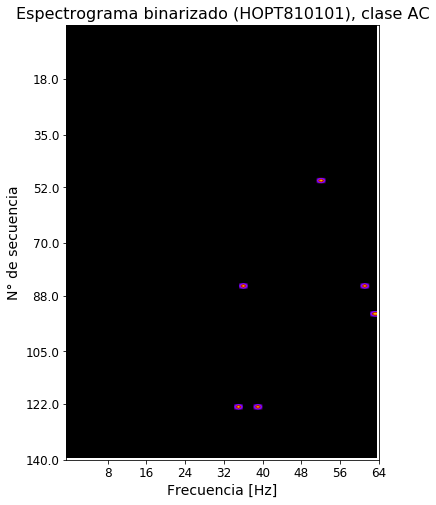

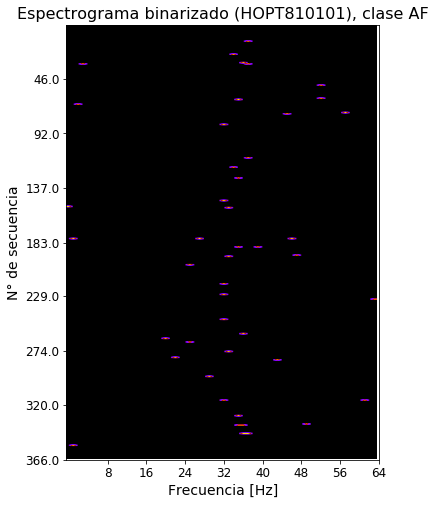

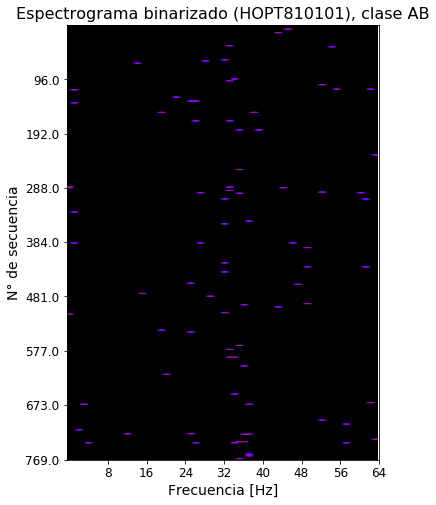

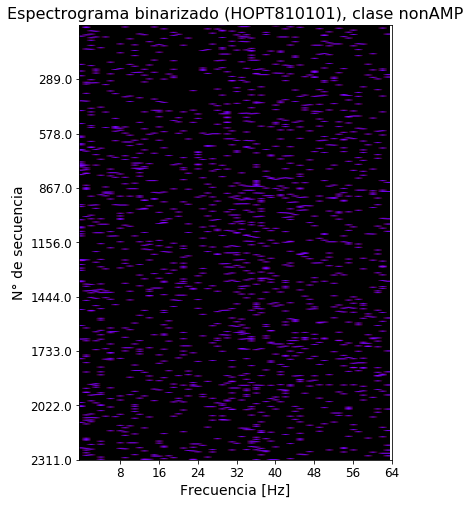

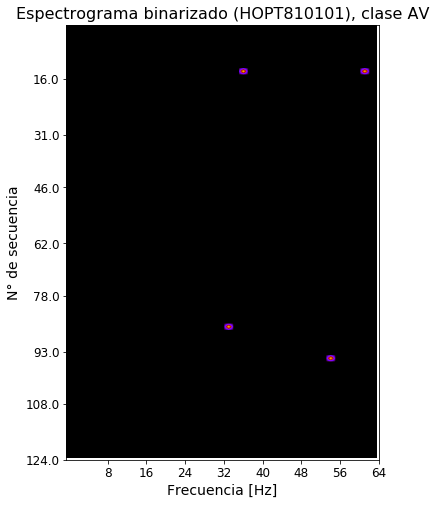

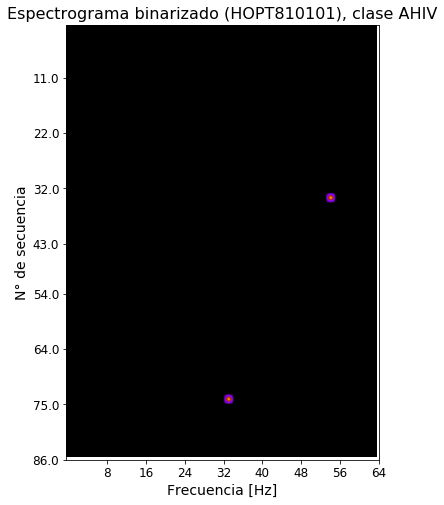

In [102]:
props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
prop = props[3]
name = 'iAMP-2L_multiclass'
inputfile = 'C:/Users/Kevin/Desktop/Thesis graphs definite/'+prop+'/digitalization ' + prop + ' ' + name + '.csv'
exportpath = 'C:/Users/Kevin/Desktop/'
data1 = characterizations(inputfile)
subsetname = data1.subsetname
data1.remove_outliers()
#data1.dataset = data1.dataset.drop(columns=data1.dataset.columns[17:])
data1.dataset = data1.dataset.sample(frac=1).reset_index(drop=True)
#spectrum_density_filled_wo_outliers(data1,exportpath,prop,subsetname,resol=64,form='png')
#spectrum_density_binarization_wo_outliers(inputfile,exportpath,prop,subsetname,form='png')
#spectrogram_abs(data1,exportpath,prop,subsetname,form='png')
#spectrogram_abs_wo_outliers(data1,exportpath,prop,subsetname,form='png')
#spectrogram_bin(data1,exportpath,prop,subsetname,form='png')
spectrogram_bin_wo_outliers(data1,exportpath,prop,subsetname,form='png')

C:\Users\Kevin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2907: DtypeWarning: Columns (2,4,10,13,16,24,26,32,40,41,42,44,45,49,54,55,56,57,59,62,64,69,70,72,73,74,75,77,82,88,89,92,98,101,107,109,113,114,117,121,123,125,126,131,134,136,137,139,143,146,148,152,153,156,158,161,163,164,165,170,173,175,176,177,180,181,183,184,186,189,190,194,195,199,204,205,206,207,211,212,217,218,219,220,224,226,229,232,235,237,238,239,240,246,248,249,251,253,254,255,256,257,258,261,264,265,268,269,272,280,282,284,286,287,288,289,293,296,298,299,304,311,314,315,319,320,323,324,326,328,331,332,334,335,336,340,345,355,356,357,359,362,363,364,371,374,375,377,382,384,388,395,404,405,409,410,412,414,415,418,425,435,445,447,450,451,453,454,456,458,463,470,474,477,480,481,484,485,487,489,493,495,497,502,509,515,517,519,530,538,541,542,547,555,563,566,568,572,578,587,597,605,609,612,614,632,634,637,641,654,655,657,658,662,663,672,681,685,691,693,707,712,720,743,753,759,770,793,798,822,844,846,85

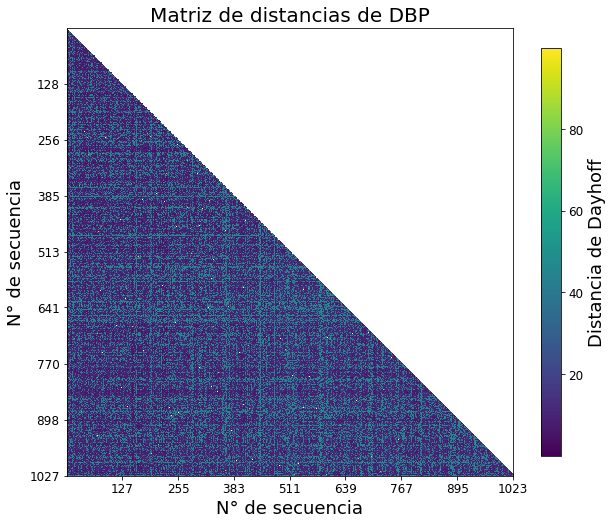

In [54]:
inputfile='C:/Users/Kevin/Desktop/DBP.csv'
exportpath ='C:/Users/Kevin/Desktop/'
alignment(inputfile,exportpath,'png')

In [ ]:
folderinput = 'C:/Users/Kevin/Desktop/Datasets CSV/'
exportpath = 'C:/Users/Kevin/Desktop/pie chart classes/'
for root,dirs,files in os.walk(folderinput):
    for file in files:
        filename = folderinput + '/' + file
        if filename.endswith(".csv"):
            print(filename)
            subset = characterizations(filename)
            subset.remove_outliers()
            subset.pie_chart_response(exportpath)

In [ ]:
props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
subsetname = 'iAMP-2L_multiclass'
for prop in [props[4]]:
    filedigit = 'C:/Users/Kevin/Desktop/' + prop + '/digitalization ' + prop + ' ' + subsetname + '.csv'
    exportdigit = 'C:/Users/Kevin/Desktop/Spectrum images without outliers/' + subsetname + ' '+ prop + '/'
    print(filedigit)
    print(exportdigit)
    image_spectrum_wo_outliers(filedigit,exportdigit,prop,subsetname)

In [ ]:
props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
subsetname = 'iAMP-2L_multiclass'
for prop in props:
    filedigit = 'C:/Users/Kevin/Desktop/' + prop + '/digitalization ' + prop + ' ' + subsetname + '.csv'
    exportdigit = 'C:/Users/Kevin/Desktop/Spectrum density without outliers/' + subsetname + '/'
    print(filedigit)
    print(exportdigit)
    print(prop)
    spectrum_density_wo_outliers(filedigit,exportdigit,prop,subsetname,resol=32,form='png')

In [ ]:
props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
subsetname = 't50'
for prop in props[:4]:
    filedigit = 'C:/Users/Kevin/Desktop/' + prop + '/digitalization ' + prop + ' ' + subsetname + '.csv'
    exportdigit = 'C:/Users/Kevin/Desktop/Spectrum binarization without outliers/' + subsetname + ' ' + prop + '/'
    print(filedigit)
    print(exportdigit)
    print(prop)
    spectrum_binarization_wo_outliers(filedigit,exportdigit,prop,subsetname,form='jpeg')

In [ ]:
props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
subsetname = 'DBP'
for prop in [props[7]]:
    filedigit = 'C:/Users/Kevin/Desktop/' + prop + '/digitalization ' + prop + ' ' + subsetname + '.csv'
    exportdigit = 'C:/Users/Kevin/Desktop/Spectrum density binarization without outliers/' + subsetname + '/'
    print(filedigit)
    print(exportdigit)
    print(prop)
    spectrum_density_binarization_wo_outliers(filedigit,exportdigit,prop,subsetname,form='png')

In [ ]:
props = ['PRAM900102','PRAM900103','COSI940101','HOPT810101','JOND750101','RADA880106','GRAR740103','FASG760101']
subsetname = 'DBP'
for prop in [props[7]]:
    filedigit = 'C:/Users/Kevin/Desktop/' + prop + '/digitalization ' + prop + ' ' + subsetname + '.csv'
    exportdigit = 'C:/Users/Kevin/Desktop/Spectrogram binary without outliers/' + subsetname + '/'
    print(filedigit)
    print(exportdigit)
    print(prop)
    spectrogram_bin_wo_outliers(filedigit,exportdigit,prop,subsetname,form='png')

In [10]:
A=[1,2,3,4,5,6]
print(A[-3:])
print(A[:-3])
print(np.flip(A))

[4, 5, 6]
[1, 2, 3]
[6 5 4 3 2 1]
